# Post-processing for the eigenvalue problem

This notebook *should* contain the following sections:
- Plotting and filtering of eigenspectra;
- Visualization of selected eigenmodes

In [7]:
%load_ext autoreload
%autoreload 2

import os, h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils, pgpy_utils, tools
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
plt.close('all')

---
## Eigenspectra

Read in data

In [89]:
import h5py

# fname = "./out/T1__eigenspec_non-garlerkin__m1__E_eta_1.0e-04__none_parities.h5"
# fname = "./out/T1pi__eigenspec__m1__E_eta_1.0e-10__none_parities.h5"
# fname = "./runs/T1_1e-4_m1_30-40_parity-same/eigenspectra.h5"
# fname = "./runs/T1pi_1e-4_m1_30-40_parity-same/eigenspectra.h5"
# fname = "./runs/S1_1e-6_m3_galerkin_30-40_parity-oppo/eigenspectra.h5"
# fname = "./runs/S1pi_1e-6_m1_parity-oppo/eigenspectra_all.h5"
# fname = "./runs/S1pi_1e-6_m3_galerkin_30-40_parity-oppo/eigenspectra.h5"
# fname = "./runs/S1_Em5e-9_Els5e-1_m3_parity_oppo/eigenspectra.h5"
# fname = "./runs/S1_Le1e-4_Lu1e+4_m3_parity_oppo/eigenspectra.h5"
# fname = "./runs/S1pi_1e-9_m1_galerkin_60_parity-oppo/eigenspectra.h5"
# fname = "./runs/S1pi_1e-9_m3_galerkin_60_parity-oppo/eigenspectra.h5"
# fname = "./runs/M_ideal_Le1e-4_m3_30-40_parity-same/eigenspectra.h5"
# fname = "./runs/S1pi_Le1e-4_Lu5e+4_m3_parity_oppo/eigenspectra.h5"
# fname = "./runs/S1pi_Le1e-3_Lu5e+3_m3_parity_oppo/eigenspectra.h5"
# fname = "./runs/S1pi_Le1e-5_Lu5e+5_m3_parity_oppo/eigenspectra.h5"
# fname = "./runs/S1pi_Le2e-3_Lu1e+3_m1_parity_oppo/eigenspectra.h5"
# fname = "./runs/S1pi_ideal_Le1e-4_m3_parity_oppo/eigenspectra.h5"
# fname = "./runs/S1pi_Le1e-4_Lu2e+4_m1_parity_oppo/eigenspectra.h5"
# fname = "./runs/S1c_Le1e-4_Lu2e+2_m1_parity_oppo/eigenspectra.h5"
fname = './runs/QGP-SL2N2_Le2_5e-5_Lu5e+3_m3/eigenspectra.h5'
Le = 0.25e-4
Lu = 0.5e+4

# Which parity to choose. If both QP and DP, use "both"; if the parity is not separated, use None
parity_mode = 'QP'

meta = list()
spectra = list()
with h5py.File(fname, 'r') as fread:
    n_res = len([key for key in fread.keys() if key[:9] == "eigenspec"])
    for i_res in range(n_res):
        gp = fread[f"eigenspec_res{i_res}"]
        meta.append({key: gp.attrs[key] for key in gp.attrs.keys()})
        if parity_mode is None:
            spectra.append(gp["spectrum"][()])
        elif parity_mode == "both":
            spectra.append(np.concatenate((gp["spectrum_QP"][()], gp["spectrum_DP"][()])))
        else:
            spectra.append(gp["spectrum_%s" % parity_mode][()])

In [90]:
meta

[{'L': 33, 'N': 33, 'm': 3},
 {'L': 43, 'N': 43, 'm': 3},
 {'L': 63, 'N': 63, 'm': 3}]

Sorting eigenvalues (optional)

In [91]:
for i_w, w in enumerate(spectra):
    sort_idx = np.argsort(np.imag(w))
    spectra[i_w] = w[sort_idx]

Convert to Alfven scale (optional)

In [6]:
scale = np.sqrt(1e-9/1.0)

for i_w, w in enumerate(spectra):
    spectra[i_w] = scale*w

### Eigenvalue drift plot

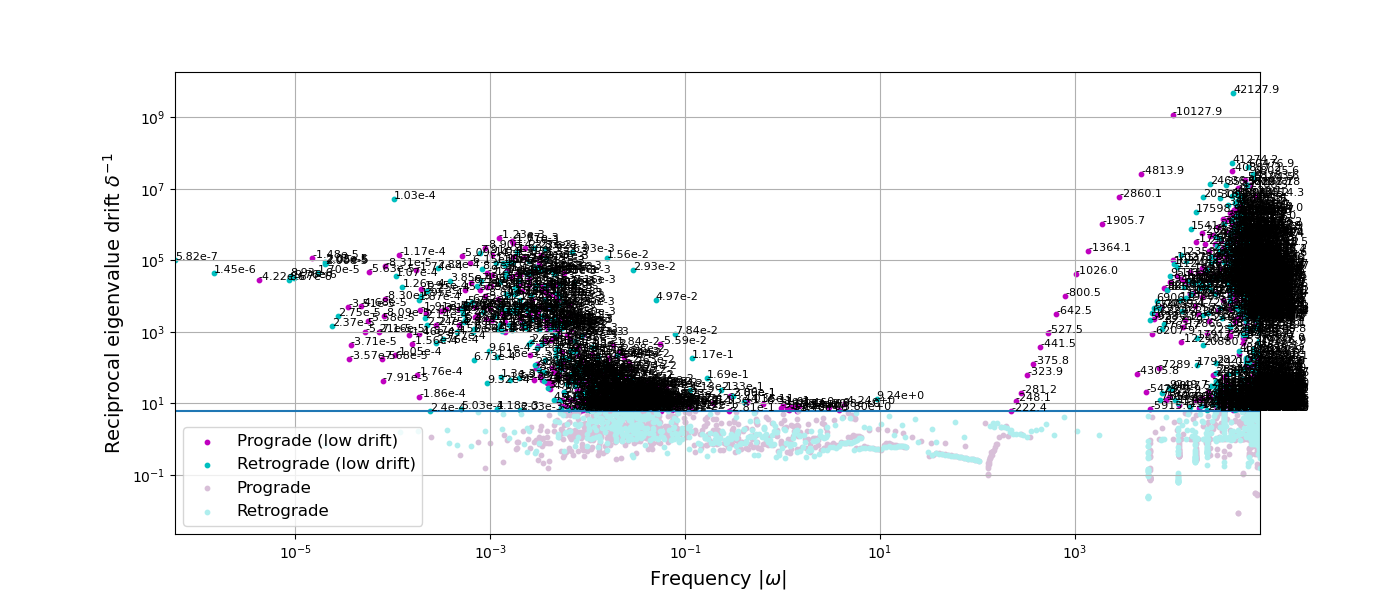

In [92]:
eig_base, eig_comp = spectra[1], spectra[2]
drift, nearest_idx = pgpy_utils.eigen_drift(eig_base, eig_comp, mode="global")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

threshold = .6e+1
reciproc = 1./drift
idx = np.arange(drift.size)

classify_list = [
    [lambda x: (x.imag < 0) & (reciproc > threshold), {"s": 10, "marker": 'o', "color": "m", "label": "Prograde (low drift)"}],
    [lambda x: (x.imag >= 0) & (reciproc > threshold), {"s": 10, "marker": 'o', "color": "c", "label": "Retrograde (low drift)"}],
    [lambda x: (x.imag < 0) & (reciproc <= threshold), {"s": 10, "marker": 'o', "color": "thistle", "label": "Prograde"}],
    [lambda x: (x.imag >= 0) & (reciproc <= threshold), {"s": 10, "marker": 'o', "color": "paleturquoise", "label": "Retrograde"}]
]

# classify_list = [
#     [lambda x: (x.imag < 1) & (x.imag > 0) & (reciproc > threshold), {"s": 20, "marker": 'o', "color": "c", "label": "Retrograde (low drift)"}],
# ]

for classifier in classify_list:
    class_idx = classifier[0](eig_base)
    ax.scatter(np.abs(eig_base[class_idx].imag), reciproc[class_idx], **classifier[1])

for idx_tmp in idx[reciproc > threshold]:
    if np.abs(eig_base[idx_tmp].imag) > 10:
        ax.annotate("{:.1f}".format(eig_base[idx_tmp].imag), (np.abs(eig_base[idx_tmp].imag), reciproc[idx_tmp]), fontsize=8)
    else:
        ax.annotate(np.format_float_scientific(eig_base[idx_tmp].imag, precision=2, exp_digits=1), (np.abs(eig_base[idx_tmp].imag), reciproc[idx_tmp]), fontsize=8)
    # ax.annotate("{:.2e}".format(eig_base[idx_tmp].imag).replace('e'), (np.abs(eig_base[idx_tmp].imag), reciproc[idx_tmp]), fontsize=8)

ax.hlines([threshold,], np.abs(eig_base.imag).min(), np.abs(eig_base.imag).max())
ax.legend(fontsize=12, loc=3)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.abs(eig_base.imag).min(), np.abs(eig_base.imag).max()])
# ax.set_xlim([10, np.abs(eig_base.imag).max()])
# ax.set_xlim([1e-3, 1])
ax.set_xlabel(r"Frequency $|\omega|$", fontsize=14)
ax.set_ylabel(r"Reciprocal eigenvalue drift $\delta^{-1}$", fontsize=14)
ax.grid(which="both")

plt.show()
# plt.ion()

Eigenvalues in different resolutions in $\omega$-$\sigma$ space

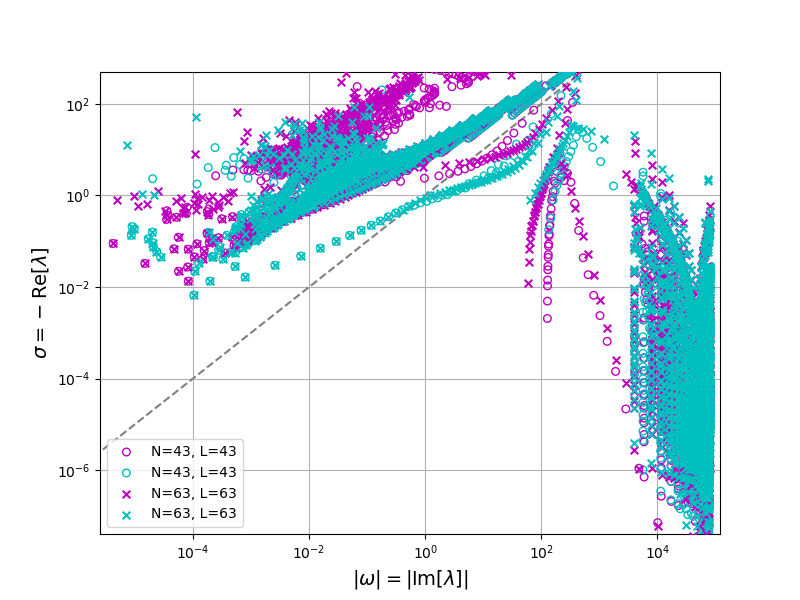

In [93]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
# ax.clear()

vrange = [np.log10(reciproc.min()), np.log10(reciproc.max())]

view_indices = [1, 2]
res_style_list = [
    # {"s": 50, "marker": 's', "facecolor": "none"},
    {"s": 30, "marker": 'o', "facecolor": "none"},
    {"s": 30, "marker": 'x'}
]

classify_list = [
    [lambda x: (x.imag < 0), {"color": 'm'}],
    [lambda x: (x.imag >= 0), {"color": 'c'}],
]

for i_view, i_res in enumerate(view_indices):
    spec = spectra[i_res]
    for classifier in classify_list:
        class_idx = classifier[0](spec)
        im = ax.scatter(np.abs(np.imag(spec[class_idx])), np.abs(np.real(spec[class_idx])), 
            **classifier[1], **res_style_list[i_view], label=f"N={meta[i_res]['N']}, L={meta[i_res]['L']}", zorder=4)

ax.plot([1e-6, 1e+8], [1e-6, 1e+8], '--', color="gray")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.1*Le, 3.0/Le])
ax.set_ylim([1/Lu**2, 0.1*Lu])
ax.set_xlabel(r"$|\omega| = |\mathrm{Im}[\lambda]|$", fontsize=14)
ax.set_ylabel(r"$\sigma = -\mathrm{Re}[\lambda]$", fontsize=14)
ax.grid(True, which="both")
ax.legend(fontsize=10, loc=3)

plt.show()

Locating the branches

In [71]:
pgpy_utils.eigenfreq_Malkus_3d(3, np.arange(1, 11), Le=2.5e-5, mode='fast', timescale='alfven')

array([-10127.89155332,  -4749.59123199,  -2827.15223168,  -1888.54866056,
        -1354.44334529,  -1020.12083972,   -796.51246763,   -639.41213285,
         -524.74616997,   -438.45794273])

In [94]:
eigval_targets = [
    # -2532j, -1204j, -715j, -477j, -342j, -257j, -201j,
    # -5064j, -2407j, -1430j, -953j, -683j, -515j, -403j, -326j, -265j, -223j,
    -10127.9j, -4813.9j, -2860j, -1906j, -1364j, -1027j, -800j, -642j, -527j, -441j,
    # +0.020j-0.022, +0.101j-0.049, +0.28j-0.084, +0.62j-0.13, +1.14j-0.18, +1.95j-0.24,
    # +3.01j-0.30, +4.47j-0.37, +6.36j-0.45, +8.68j-0.52
    # +0.0101j-0.011, +0.0503j-0.0246, +0.139j-0.042, +0.312j-0.064,
    # +0.586j-0.089, +0.973j-0.120, +1.52j-0.15, +2.28j-0.19, +3.28j-0.23,
    # +0.017j-0.031, +0.069j-0.072, +0.182j-0.135, +0.361j-0.224, +0.645j-0.319, +1.02j-0.43,
    # +1.57j-0.57, +2.33j-0.70, +3.3j-0.83, +4.5j-1.04,\
    # +0.00029j-0.00176, +0.0033j-0.0040, +0.0123j-0.0092, +0.0296j-0.0149, +0.0599j-0.023, +0.107j-0.033,
    # +0.172j-0.045, +0.271j-0.059, +0.407j-0.075
    # +0.00020j-0.0034, +0.0017j-0.0083, +0.0060j-0.0160, +0.0147j-0.0263, +0.0299j-0.0403, +0.053j-0.057,
    # +0.087j-0.079, +0.14j-0.10, +0.20j-0.13, +0.28j-0.16
    +0.000105j-0.00641, +0.00080j-0.0159, +0.0026j-0.029, +0.0075j-0.0461, +0.016j-0.070, +0.031j-0.094,
    +0.050j-0.130, +0.080j-0.169, +0.120j-0.215, +0.172j-0.267,
]
eigval_resolved = np.array([spectra[-1][np.argmin(np.abs(spectra[-1] - eig_tmp))] for eig_tmp in eigval_targets])

In [97]:
for e_tmp in eigval_resolved[np.argsort(np.abs(np.imag(eigval_resolved))).astype(int)]:
    print('{:.9f}{:+.8f}j'.format(np.real(e_tmp), np.imag(e_tmp)))

-0.006644773+0.00010296j
-0.016505346+0.00079127j
-0.029828191+0.00256908j
-0.047605766+0.00715923j
-0.070699481+0.01562015j
-0.099271381+0.02926004j
-0.133834698+0.04971487j
-0.174759162+0.07841932j
-0.222508097+0.11706500j
-0.277489121+0.16740563j
-0.274824973-441.37063203j
-0.133097966-527.50125775j
-0.053183594-642.46510017j
-0.018066951-800.48063314j
-0.005234041-1025.99861615j
-0.001284886-1364.06137549j
-0.000258012-1905.67133932j
0.000078135-2860.07438652j
-0.000001073-4813.86841314j
-0.000000060-10127.89096748j


Reciprocal eigenvalue drift in $\omega$-$\sigma$ space

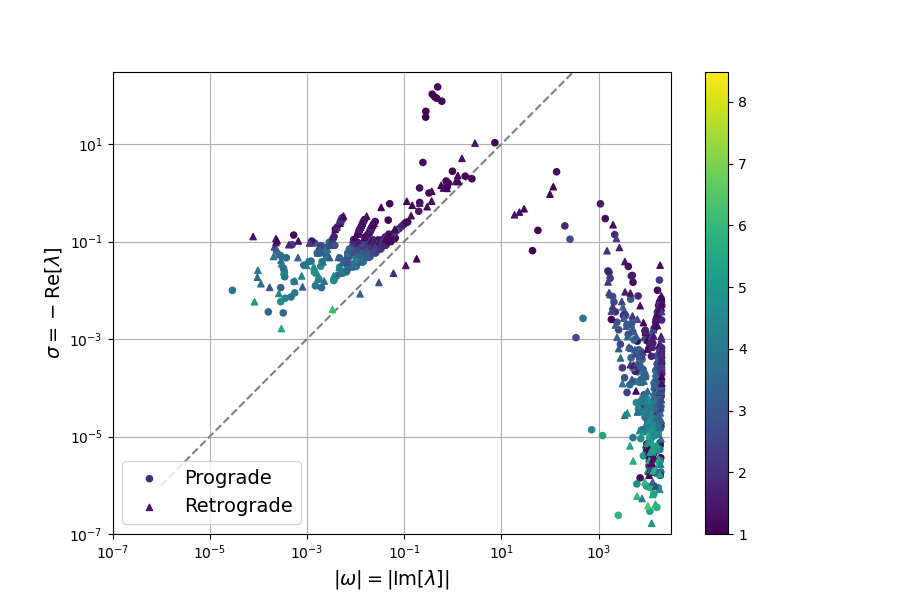

In [107]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
# ax.clear()

vrange = [np.log10(reciproc.min()), np.log10(reciproc.max())]

# classify_list = [
#     [lambda x: (x.imag < 0), {"s": 20, "marker": 'o', "label": "Prograde", "vmin": vrange[0], "vmax": vrange[1]}],
#     [lambda x: (x.imag >= 0), {"s": 20, "marker": '^', "label": "Retrograde", "vmin": vrange[0], "vmax": vrange[1]}],
# ]

# for classifier in classify_list:
#     class_idx = classifier[0](eig_base)
#     im = ax.scatter(np.abs(np.imag(eig_base[class_idx])), np.abs(np.real(eig_base[class_idx])), c=np.log10(reciproc[class_idx]), **classifier[1], zorder=5)

classify_list = [
    [lambda x: (x.imag < 0), {"s": 20, "marker": 'o', "label": "Prograde", "vmin": rcpc_vmin, "vmax": vrange[1]}],
    [lambda x: (x.imag >= 0), {"s": 20, "marker": '^', "label": "Retrograde", "vmin": rcpc_vmin, "vmax": vrange[1]}],
]

rcpc_vmin = 1
convergence_filter = np.log10(reciproc) > rcpc_vmin

for classifier in classify_list:
    class_idx = classifier[0](eig_base) & convergence_filter
    im = ax.scatter(np.abs(np.imag(eig_base[class_idx])), np.abs(np.real(eig_base[class_idx])), c=np.log10(reciproc[class_idx]), **classifier[1], zorder=5)

plt.colorbar(im, ax=ax)

ax.plot([1e-6, 1e+8], [1e-6, 1e+8], '--', color="gray")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-7, 3.0/Le])
ax.set_ylim([1e-7, 3.0e+2])
# ax.set_xlim([1e-6, 2.5e+5])
# ax.set_ylim([1e-5, 2.5e+1])

ax.set_xlabel(r"$|\omega| = |\mathrm{Im}[\lambda]|$", fontsize=14)
ax.set_ylabel(r"$\sigma = -\mathrm{Re}[\lambda]$", fontsize=14)
ax.grid(which="both")
ax.legend(fontsize=14, loc=3)

plt.show()

### Output

Eigenfrequency spectrum output

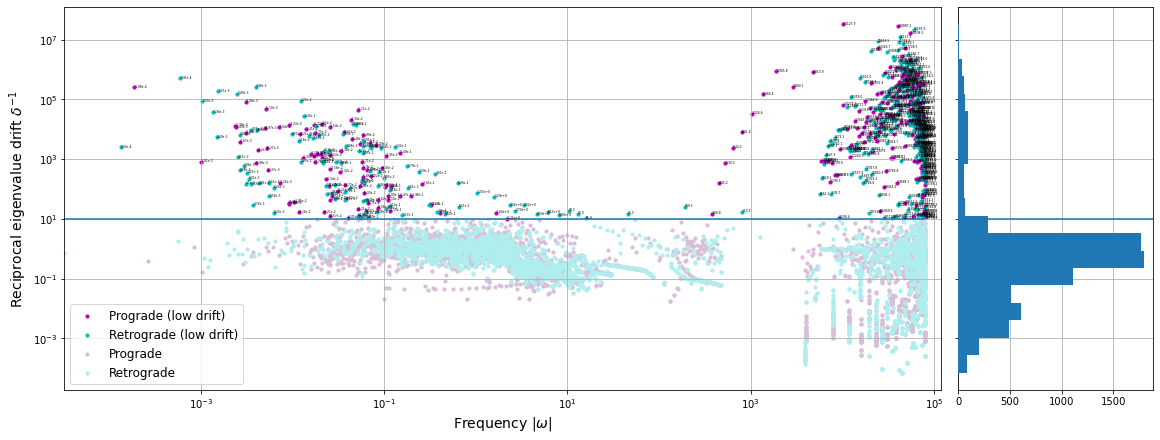

In [200]:
save_name = './runs/QGP-S2_Le2_5e-5_Lu5e+3_m3/spectra_freq_drift' 
# save_name = None

eig_base, eig_comp = spectra[2], spectra[1]
drift, nearest_idx = pgpy_utils.eigen_drift(eig_base, eig_comp, mode="global")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), gridspec_kw={'width_ratios': (9, 2)}, sharey=True, layout='constrained')

threshold = 1.e+1
reciproc = 1./drift
drift_r = drift/np.abs(eig_base)
idx = np.arange(drift.size)

classify_list = [
    [lambda x: (x.imag < 0) & (reciproc > threshold), {"s": 10, "marker": 'o', "color": "m", "label": "Prograde (low drift)"}],
    [lambda x: (x.imag >= 0) & (reciproc > threshold), {"s": 10, "marker": 'o', "color": "c", "label": "Retrograde (low drift)"}],
    [lambda x: (x.imag < 0) & (reciproc <= threshold), {"s": 10, "marker": 'o', "color": "thistle", "label": "Prograde"}],
    [lambda x: (x.imag >= 0) & (reciproc <= threshold), {"s": 10, "marker": 'o', "color": "paleturquoise", "label": "Retrograde"}]
]

ax = axes[0]
for classifier in classify_list:
    class_idx = classifier[0](eig_base)
    ax.scatter(np.abs(eig_base[class_idx].imag), reciproc[class_idx], **classifier[1])

ax.hlines([threshold,], np.abs(eig_base.imag).min(), np.abs(eig_base.imag).max())
ax.legend(fontsize=12, loc=3)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.abs(eig_base.imag).min(), 3./Le])
# ax.set_xlim([10, np.abs(eig_base.imag).max()])
# ax.set_xlim([1e-3, 1])
ax.set_xlabel(r"Frequency $|\omega|$", fontsize=14)
ax.set_ylabel(r"Reciprocal eigenvalue drift $\delta^{-1}$", fontsize=14)
ax.grid(which="both")

ax = axes[1]
nbins = 20
bin_edges = np.power(10, np.histogram_bin_edges(np.log10(reciproc), bins=nbins))
ax.hist(reciproc, bins=bin_edges, orientation="horizontal", zorder=3)
xlimits = ax.get_xlim()

ax.hlines([threshold,], *xlimits)
ax.grid(which="both")
ax.set_xlim(*xlimits)

if save_name is not None:
    plt.savefig(save_name + '.png', dpi=150, bbox_inches='tight')
    
ax = axes[0]
for idx_tmp in idx[reciproc > threshold]:
    if np.abs(eig_base[idx_tmp].imag) > 10:
        ax.annotate("{:.1f}".format(eig_base[idx_tmp].imag), (np.abs(eig_base[idx_tmp].imag), reciproc[idx_tmp]), fontsize=3)
    else:
        ax.annotate(np.format_float_scientific(eig_base[idx_tmp].imag, precision=2, exp_digits=1), (np.abs(eig_base[idx_tmp].imag), reciproc[idx_tmp]), fontsize=3)
        
if save_name is not None:
    plt.savefig(save_name + '.pdf', bbox_inches='tight')

plt.show()

Eigenspectra

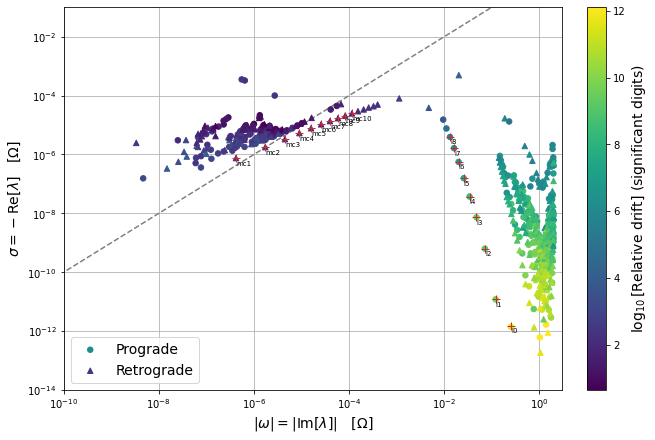

In [202]:
save_name = './runs/QGP-S2_Le2_5e-5_Lu5e+3_m3/spectra_c_thresh10'
# save_name = None

# c_mode = 'reciprocal_drift'
c_mode = 'significant_digit'

# t_unit = 'Alfven'
t_unit = 'rotation'

# fixed_lims = False
fixed_lims = True

# selected_file = None
selected_file = './runs/QGP-S2_Le2_5e-5_Lu5e+3_m3/eigenspectra_describe.txt'


rcpc_vmin = 10.
convergence_filter = reciproc > rcpc_vmin

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6), layout='constrained')

classify_options = {
    'reciprocal_drift': [
        [lambda x: (x.imag < 0), {"s": 30, "marker": 'o', "label": "Prograde", "vmin": np.log10(rcpc_vmin), "vmax": np.log10(reciproc.max())}],
        [lambda x: (x.imag >= 0), {"s": 30, "marker": '^', "label": "Retrograde", "vmin": np.log10(rcpc_vmin), "vmax": np.log10(reciproc.max())}],
    ],
    'significant_digit': [
        [lambda x: (x.imag < 0), {"s": 30, "marker": 'o', "label": "Prograde"}],
        [lambda x: (x.imag >= 0), {"s": 30, "marker": '^', "label": "Retrograde"}],
    ]
}
cbar_title_options = {
    'reciprocal_drift': r'$\log_{10}$[Reciprocal drift]',
    'significant_digit': r'$\log_{10}$[Relative drift] (significant digits)'
}
unit_names = {
    'Alfven': r'V_A/L',
    'rotation': r'\Omega'
}

classify_list = classify_options[c_mode]
t_factor, _ = pgpy_utils.tscale_convert(in_tscale='Alfven', out_tscale=t_unit, Lehnert=Le, Lundquist=Lu)

for classifier in classify_list:
    class_idx = classifier[0](eig_base) & convergence_filter
    c_values = reciproc if c_mode == 'reciprocal_drift' else 1/drift_r
    im = ax.scatter(np.abs(np.imag(eig_base[class_idx]))/t_factor, np.abs(np.real(eig_base[class_idx]))/t_factor, c=np.log10(c_values[class_idx]), **classifier[1], zorder=5)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label(cbar_title_options[c_mode], fontsize=14)

ax.plot([1e-15, 1e+8], [1e-15, 1e+8], '--', color="gray")

ax.set_xscale('log')
ax.set_yscale('log')
if t_unit == 'Alfven':
    if fixed_lims:
        ax.set_xlim([1e-6, 3.0e+5])
        ax.set_ylim([1e-10, 1e+4])
    else:
        ax.set_xlim([0.1*Le, 3.0/Le])
        ax.set_ylim([0.1*Le/Lu, 0.1/Le])
elif t_unit == 'rotation':
    if fixed_lims:
        ax.set_xlim([1e-10, 3.])
        ax.set_ylim([1e-14, 0.1])
    else:
        ax.set_xlim([0.1*Le**2, 3.])
        ax.set_ylim([0.1*Le**2/Lu, 0.1*Le*Lu])

ax.set_xlabel(r"$|\omega| = |\mathrm{Im}[\lambda]| \quad [%s]$" % (unit_names[t_unit],), fontsize=14)
ax.set_ylabel(r"$\sigma = -\mathrm{Re}[\lambda] \quad [%s]$" % (unit_names[t_unit]), fontsize=14)
ax.grid(which="both")
ax.legend(fontsize=14, loc=3)

if save_name is not None:
    save_name = save_name + '_{}'.format(t_unit)
    if fixed_lims:
        save_name = save_name + '_fixed'
    plt.savefig(save_name + '.png', dpi=150, bbox_inches='tight')
    
if selected_file is not None:
    df_selected = pd.read_table(selected_file, header=3, delimiter='\s+')
    eig_selected = df_selected['Value'].to_numpy().astype(np.complex128)
    ax.scatter(np.abs(np.imag(eig_selected))/t_factor, np.abs(np.real(eig_selected))/t_factor, s=50, marker='+', color='tab:red', linewidths=1, zorder=5)
    for i_eig, eig_text in enumerate(df_selected['Index']):
        ax.annotate(eig_text, (np.abs(np.imag(eig_selected[i_eig]))/t_factor, np.abs(np.real(eig_selected[i_eig]))/t_factor), 
                    xytext=(0, -0.3), textcoords='offset fontsize', fontsize=7, va='top', zorder=5)

if save_name is not None:
    plt.savefig(save_name + '.pdf', bbox_inches='tight')
plt.show()

### Filtered eigenspectrum

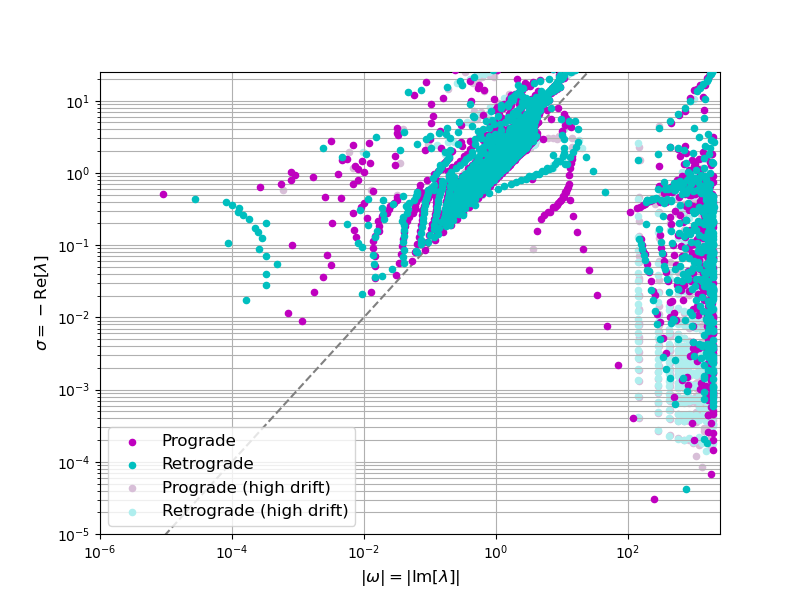

In [49]:
threshold = 1e+0
converge_filter = reciproc > threshold

# spectrum_converged = eig_base[converge_filter]
spectrum_converged = eig_base

classify_list = [
    [lambda x: x.imag < -1e-7, {"s": 20, "marker": 'o', "color": "m", "label": "Prograde"}],
    [lambda x: x.imag > +1e-7, {"s": 20, "marker": 'o', "color": "c", "label": "Retrograde"}]
]
classify_list = [
    [lambda x: (x.imag < -1e-7) & (reciproc > threshold), 
     {"s": 20, "marker": 'o', "color": "m", "label": "Prograde", "zorder": 5}],
    [lambda x: (x.imag > +1e-7) & (reciproc > threshold), 
     {"s": 20, "marker": 'o', "color": "c", "label": "Retrograde", "zorder": 5}],
    [lambda x: (x.imag < -1e-7) & (reciproc <= threshold), 
     {"s": 20, "marker": 'o', "color": "thistle", "label": "Prograde (high drift)", "zorder": 1}],
    [lambda x: (x.imag > +1e-7) & (reciproc <= threshold), 
     {"s": 20, "marker": 'o', "color": "paleturquoise", "label": "Retrograde (high drift)", "zorder": 1}]
]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

for classifier in classify_list:
    class_idx = classifier[0](spectrum_converged)
    ax.scatter(np.abs(np.imag(spectrum_converged[class_idx])), -np.real(spectrum_converged[class_idx]), **classifier[1])

ax.plot([1e-6, 1e+8], [1e-6, 1e+8], '--', color="gray")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-6, 2.5e+3])
ax.set_ylim([1e-5, 2.5e+1])

ax.set_xlabel(r"$|\omega| = |\mathrm{Im}[\lambda]|$", fontsize=12)
ax.set_ylabel(r"$\sigma = -\mathrm{Re}[\lambda]$", fontsize=12)
ax.grid(which="both")
ax.legend(fontsize=12, loc=3)

# plt.savefig("./out/eigenspec_T1__E1e-4_m1_N40__QP_thresh_1e8.png", format="png", dpi=150, bbox_inches="tight")
plt.show()

### Comparison Malkus model

In [29]:
import pandas as pd

omega_fast, omega_slow = pgpy_utils.eigenfreq_Malkus_3d(m=3, n=np.arange(1, 20), Le=np.sqrt(2)*1e-4, mode="all", timescale="alfven")

df_original = pd.DataFrame(data={"Fast": omega_fast, "Slow": omega_slow})
df_original

Fast      Slow
0  -1790.380480  0.005451
1   -839.627837  0.011143
2   -499.792484  0.018432
3   -333.877916  0.027380
4   -239.470838  0.038007
5   -180.382336  0.050318
6   -140.867145  0.064314
7   -113.110654  0.079992
8    -92.857195  0.097347
9    -77.621875  0.116370
10   -65.872249  0.137051
11   -56.620576  0.159376
12   -49.206509  0.183325
13   -43.174787  0.208877
14   -38.203168  0.236004
15   -34.058311  0.264674
16   -30.567851  0.294847
17   -27.602204  0.326480
18   -25.062411  0.359522

In [31]:
b_pref = 2*np.sqrt(np.pi/3)
Le_pref = np.sqrt(2)
omega_fast, omega_slow = pgpy_utils.eigenfreq_Malkus_3d(m=3, n=np.arange(1, 20), Le=Le_pref*np.sqrt(2)*1e-4, mode="all", timescale="alfven")

df_scaled = pd.DataFrame(data={"Fast": omega_fast*Le_pref, "Slow": omega_slow*Le_pref})
df_scaled

Fast      Slow
0  -1790.385931  0.010902
1   -839.638980  0.022286
2   -499.810915  0.036862
3   -333.905291  0.054756
4   -239.508833  0.076002
5   -180.432626  0.100608
6   -140.931401  0.128569
7   -113.190534  0.159871
8    -92.954339  0.194490
9    -77.737898  0.232393
10   -66.008734  0.273536
11   -56.779062  0.317862
12   -49.388484  0.365300
13   -43.381672  0.415762
14   -38.436309  0.469145
15   -34.318964  0.525327
16   -30.857170  0.584165
17   -27.921224  0.645500
18   -25.412040  0.709151

In [26]:
spectra[1][(reciproc > 1e+2) & (spectra[1].imag > 1e-3) & (spectra[1].imag < 1)]
# spectra[1][(reciproc > 1e+4) & (spectra[1].imag < 0)]

array([-1.07292790e-08+0.0015428j ,  3.51933742e-11+0.00177292j,
        2.66224128e-09+0.00198239j,  2.07175263e-09+0.00210012j,
        6.87994566e-09+0.00321739j, -2.22426649e-11+0.00582257j,
       -1.36651752e-08+0.25582753j, -1.01941042e-20+0.25582756j,
        1.60155943e-12+0.25582757j, -4.86101668e-13+0.25582757j,
       -3.96482053e-13+0.25582757j, -1.72323545e-12+0.25582757j,
        1.12698150e-20+0.25582757j,  5.56864117e-13+0.25582757j,
       -3.24640971e-13+0.25582757j,  6.96252048e-13+0.25582757j,
       -2.47991110e-13+0.25582757j,  7.79789473e-22+0.25582757j,
        1.73225119e-13+0.25582757j, -1.51957875e-13+0.25582757j,
       -5.33426939e-14+0.25582757j,  5.40614498e-20+0.25582757j,
       -1.19974021e-13+0.25582757j,  6.68106419e-14+0.25582757j,
        3.03952456e-20+0.25582757j, -2.16762332e-13+0.25582757j,
        4.35708003e-14+0.25582757j,  1.98241706e-17+0.25582757j,
        1.62153414e-13+0.25582757j, -3.49508831e-19+0.25582757j,
        2.32822951e-22+0.

---
## Eigenmodes

In [6]:
import models
from operators.polynomials import SphericalHarmonicMode
from operators.worland_transform import WorlandTransform
from operators.associated_legendre_transform import AssociatedLegendreTransformSingleM
from fields import VectorFieldSingleM

nr, maxnl, m_val = 63, 63, 3

model = models.MagnetoCoriolis_Alfven(nr, maxnl, m_val, inviscid=True,
    induction_eq_params={'galerkin': False, 'ideal': False, 'boundary_condition': True})

### Read pre-computed

In [30]:
eigenvals = list()
eigenvecs = list()
with h5py.File("./runs/S1pi_Le1e-4_Lu2e+4_m1_parity_oppo/eigenmodes.h5", 'r') as fread:
    n_gps = len(fread.keys())
    for i_gps in range(n_gps):
        eigenvals.append(fread[f"eigenmode_target{i_gps}"]["eigenvals"][()])
        eigenvecs.append(fread[f"eigenmode_target{i_gps}"]["eigenvecs"][()])
eigenvals

[array([-0.00523733+0.00190438j]),
 array([-0.00742772+0.00344263j]),
 array([-0.01363325+0.00905602j]),
 array([-0.02269768+0.01999058j]),
 array([-0.03496658+0.03793514j]),
 array([-0.05069637+0.06512889j]),
 array([-0.09471151+0.15796508j]),
 array([-0.00087184-256.49612101j])]

### Choose mode

In [7]:
category_idx = 7
mode_idx = 0

rg = np.linspace(0, 1, 201)
tg = np.linspace(0, np.pi/2, 201)
worland_transform = WorlandTransform(nr, maxnl, m_val, r_grid=rg)
legendre_transform = AssociatedLegendreTransformSingleM(maxnl, m_val, tg)

usp = VectorFieldSingleM(nr, maxnl, m_val, eigenvecs[category_idx][:model.dim['u'], mode_idx])
bsp = VectorFieldSingleM(nr, maxnl, m_val, eigenvecs[category_idx][model.dim['u']:, mode_idx])
norm = np.sqrt(usp.energy)
usp.normalise(norm)
bsp.normalise(norm)

In [8]:
usp.data

array([-3.55255695e-15-6.38559011e-15j, -3.15345542e-15-5.48662228e-15j,
       -2.95355283e-15-5.38156820e-15j, ...,
        8.33732433e-18+3.10187725e-18j,  3.73804091e-18+3.75138264e-18j,
       -2.45580073e-18+8.18533357e-19j])

In [9]:
bsp.data

array([-2.85240835e+01-3.63910125e+01j, -1.85631302e+01-1.09804179e+01j,
       -2.78084841e+01+1.89952912e+01j, ...,
        3.11676964e-12-1.16609921e-11j,  1.26664728e-11+2.06346278e-11j,
        3.62291567e-13-5.76047071e-12j])

### Equatorial slice

Calculate values on the equatorial slice

In [103]:
n_phi = 200
phase = 0*np.pi
phi_grid = np.linspace(0, 2*np.pi, n_phi + 1)

uphy_eq = usp.equatorial_slice(worland_transform)
bphy_eq = bsp.equatorial_slice(worland_transform)

u_sph = uphy_eq.at_equator(phi_grid, phase=phase)
u_cyl = {'s': u_sph['r'], 'phi': u_sph['phi'], 'z': -u_sph['theta']}
b_sph = bphy_eq.at_equator(phi_grid, phase=phase)
b_cyl = {'s': b_sph['r'], 'phi': b_sph['phi'], 'z': -b_sph['theta']}

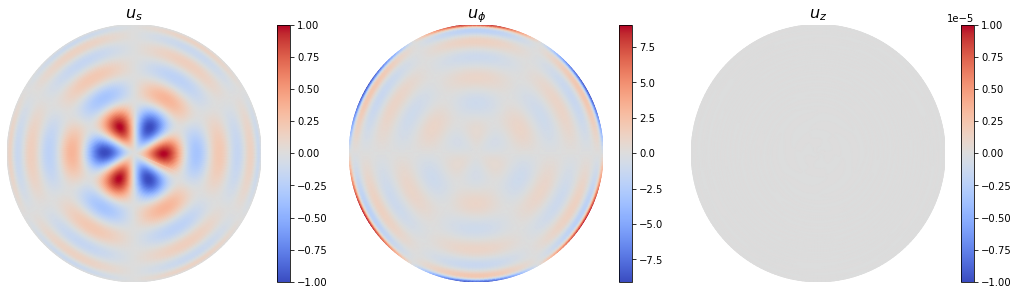

In [106]:
fields = {
    'u_r': u_sph['r'], 'u_t': u_sph['theta'],
    'u_s': u_cyl['s'], 'u_p': u_cyl['phi'], 'u_z': u_cyl['z'],
    'b_r': b_sph['r'], 'b_t': b_sph['theta'],
    'b_s': b_cyl['s'], 'b_p': b_cyl['phi'], 'b_z': b_cyl['z'],
}

# plot_fields = [["u_s", "u_p", "u_z"],
#                ["b_r", "b_t", "b_p"],]
# plot_fnames = [[r"$u_s$", r"$u_\phi$", r"$u_z$"],
#                [r"$b_r$", r"$b_\theta$", r"$b_\phi$"],]
plot_fields = [["u_s", "u_p", "u_z"],]
plot_fnames = [[r"$u_s$", r"$u_\phi$", r"$u_z$"],]

# save_name = "./runs/S1pi_Le1e-5_Lu5e+5_m3_parity_oppo/v_eq_m3_{}".format(
#     df_view["Index"][category_idx])
save_name = "./runs/S1pi_Le1e-4_Lu2e+4_m1_parity_oppo/v_eq_m3_i5"
# save_name = None
override = False

rotate_us_max = True
force_symmetric_cmap = True

max_u_norm = np.abs(u_cyl['s']).max()
# max_b_norm = np.abs(b_sph['r']).max()
# max_u_norm = np.max(u_sph['r']**2 + u_sph['theta']**2 + u_sph['phi']**2)
# max_b_norm = np.max(b_sph['r']**2 + b_sph['theta']**2 + b_sph['phi']**2)

phi_rotate = 0
if rotate_us_max:
    phi_rotate = phi_grid[np.unravel_index(np.argmax(u_cyl['s']), u_cyl['s'].shape)[0]]

rr, pp = np.meshgrid(uphy_eq.rg, phi_grid - phi_rotate)
X1, X2 = rr*np.cos(pp), rr*np.sin(pp)

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4.8, nrows*4.2))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        field_plot = fields[fname]
        if np.abs(np.real(field_plot/max_u_norm)).max() > 1e-5:
            # normalizer = max_u_norm if fname[0] == 'u' else max_b_norm
            normalizer = max_u_norm
            if force_symmetric_cmap:
                climit = np.max(np.abs(field_plot/normalizer))
                # climit = np.max(np.abs(field_plot[rr < 0.5]/normalizer))
                cm = ax.pcolormesh(X1, X2, field_plot/normalizer, shading="gouraud", cmap="coolwarm", vmin=-climit, vmax=+climit)
                plt.colorbar(cm, ax=ax)
            else:
                cm = ax.pcolormesh(X1, X2, field_plot/normalizer, shading="gouraud", cmap="coolwarm")
                plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(X1, X2, field_plot/normalizer, vmin=-1e-5, vmax=+1e-5, shading="gouraud", cmap="coolwarm")
            plt.colorbar(cm, ax=ax)
        
        ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        # ax.axis("equal")
        # ax.grid()
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.axis("off")

# fig.suptitle(r"Idx={:d}    $\lambda=${:.4e}".format(
#     category_idx, eigenvals[category_idx][mode_idx],), fontsize=16)
# fig.suptitle(r"Mode {}    $\lambda=${:.4e}".format(
#     df_view["Index"][category_idx], eigenvals[category_idx][mode_idx],), fontsize=16)
plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.show()

Unstructured points evaluation:
- Fourier grids in the azimuthal direction (equidistant grids in $\phi$)
- Jacobi (shown is Chebyshev) grids in the radial direction

In [116]:
from scipy.special import roots_jacobi, roots_chebyt

s_grid, _ = roots_jacobi(80, -0.5, -0.5)
s_grid = np.sqrt((1 + s_grid) / 2)
# s_grid = np.linspace(0., 1., num=100)
p_grid = np.linspace(0, 2*np.pi, num=200)
s_grid, p_grid = np.meshgrid(s_grid, p_grid)
x_pts = (s_grid*np.cos(p_grid)).flatten()
y_pts = (s_grid*np.sin(p_grid)).flatten()

# x_grid = np.linspace(-1, 1, num=80)
# y_grid = np.linspace(-1, 1, num=80)
# x_grid, y_grid = np.meshgrid(x_grid, y_grid)
# x_pts = x_grid.flatten()
# y_pts = y_grid.flatten()
# in_circ = x_pts**2 + y_pts**2 <= 1.
# x_pts = x_pts[in_circ]
# y_pts = y_pts[in_circ]

phase = np.exp(1j*m_val*p_grid[:, 0])
ueval = usp.evaluate(s_grid[0, :], np.pi/2*np.ones(s_grid.shape[1]), 0.)
ueval['r'] = np.outer(phase, ueval['r']).flatten()
ueval['theta'] = np.outer(phase, ueval['theta']).flatten()
ueval['phi'] = np.outer(phase, ueval['phi']).flatten()

beval = bsp.evaluate(s_grid[0, :], np.pi/2*np.ones(s_grid.shape[1]), 0.)
beval['r'] = np.outer(phase, beval['r']).flatten()
beval['theta'] = np.outer(phase, beval['theta']).flatten()
beval['phi'] = np.outer(phase, beval['phi']).flatten()

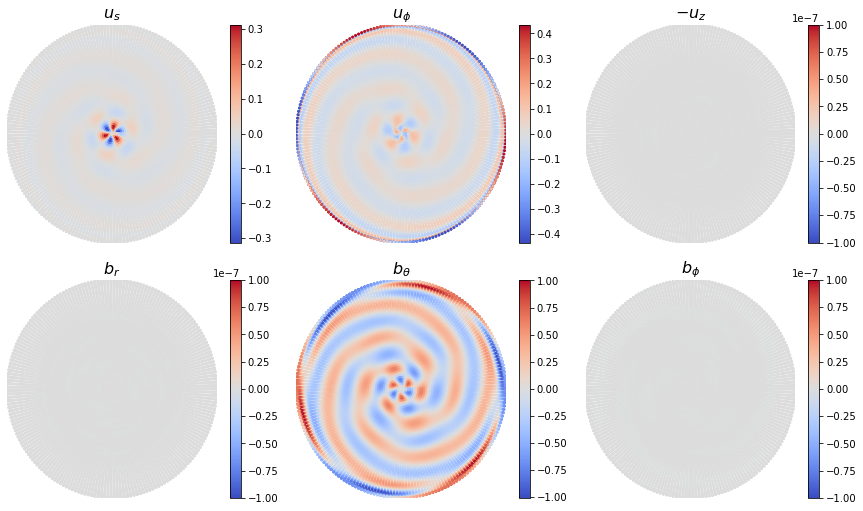

In [130]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12.2, 7.2))

# normalizer = np.abs(ueval['r']).max()
normalizer = np.abs(ueval['r']**2 + ueval['theta']**2 + ueval['phi']**2).max()

plot_fields = ['r', 'phi', 'theta']
plot_fnames = [r"$u_s$", r"$u_\phi$", r"$-u_z$"]

for i_c, comp in enumerate(plot_fields):
    # climit = 1
    if np.nanmax(np.abs(np.real(ueval[comp])))/normalizer >= 1e-7:
        climit = np.nanmax(np.abs(np.real(ueval[comp])))/normalizer
    else:
        climit = 1e-7
    ax = axes[0, i_c]
    im = ax.scatter(x_pts, y_pts, 3, c=np.real(ueval[comp])/normalizer, cmap='coolwarm', vmin=-climit, vmax=+climit)
    plt.colorbar(im, ax=ax)
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_title(plot_fnames[i_c], fontsize=16)
    ax.axis("off")

plot_fields = ['r', 'theta', 'phi']
plot_fnames = [r"$b_r$", r"$b_\theta$", r"$b_\phi$"]

for i_c, comp in enumerate(plot_fields):
    # climit = 1
    if np.nanmax(np.abs(np.real(beval[comp])))/normalizer >= 1e-7:
        climit = np.nanmax(np.abs(np.real(beval[comp])))/normalizer
    else:
        climit = 1e-7
    ax = axes[1, i_c]
    im = ax.scatter(x_pts, y_pts, 3, c=np.real(beval[comp])/normalizer, cmap='coolwarm', vmin=-climit, vmax=+climit)
    plt.colorbar(im, ax=ax)
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_title(plot_fnames[i_c], fontsize=16)
    ax.axis("off")

plt.tight_layout()
plt.show()

### Meridional slice

Calculate values on a Meridional slice

In [11]:
longitude = 0*np.pi
# longitude = phi_rotate - np.pi/12

uphy_md = usp.physical_field(worland_transform, legendre_transform)
bphy_md = bsp.physical_field(worland_transform, legendre_transform)

rr, tt = np.meshgrid(uphy_md.grid['r'], uphy_md.grid['theta'])
X1, X2 = rr*np.sin(tt), rr*np.cos(tt)

u_sph = uphy_md.at_phi(phi=longitude)
u_cyl = {
    's': u_sph['r']*np.sin(tt) + u_sph['theta']*np.cos(tt),
    'phi': u_sph['phi'],
    'z': u_sph['r']*np.cos(tt) - u_sph['theta']*np.sin(tt)
}
b_sph = bphy_md.at_phi(phi=longitude)
b_cyl = {
    's': b_sph['r']*np.sin(tt) + b_sph['theta']*np.cos(tt),
    'phi': b_sph['phi'],
    'z': b_sph['r']*np.cos(tt) - b_sph['theta']*np.sin(tt)
}

Visualisation

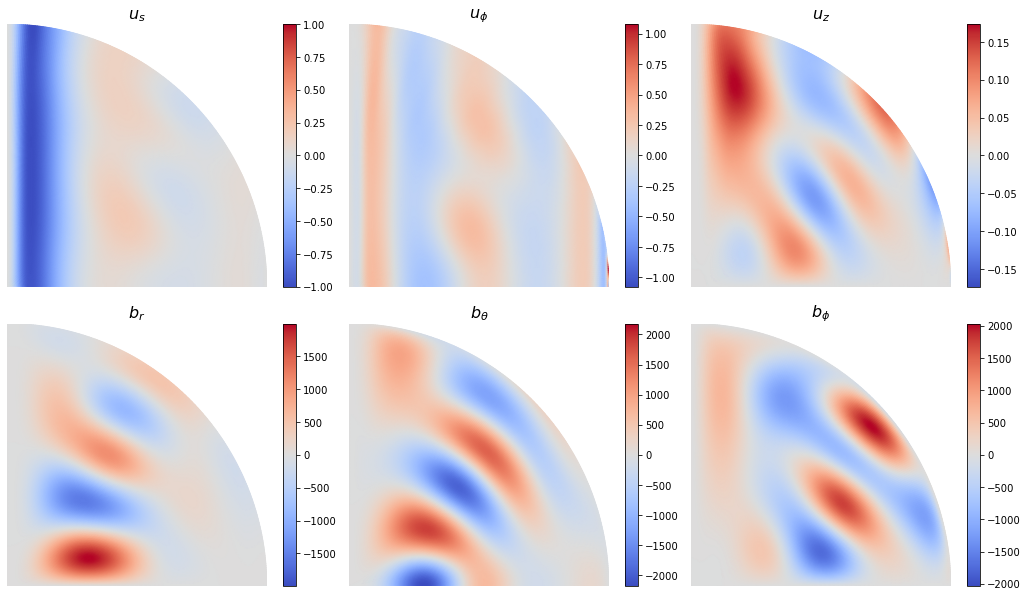

In [25]:
fields = {
    'u_r': u_sph['r'], 'u_t': u_sph['theta'],
    'u_s': u_cyl['s'], 'u_p': u_cyl['phi'], 'u_z': u_cyl['z'],
    'b_r': b_sph['r'], 'b_t': b_sph['theta'],
    'b_s': b_cyl['s'], 'b_p': b_cyl['phi'], 'b_z': b_cyl['z'],
}

plot_fields = [["u_s", "u_p", "u_z"],
               ["b_r", "b_t", "b_p"],
              ]
plot_fnames = [[r"$u_s$", r"$u_\phi$", r"$u_z$"],
               [r"$b_r$", r"$b_\theta$", r"$b_\phi$"],]

# save_name = "./runs/S1pi_Le1e-3_Lu5e+3_m3_parity_oppo/v_md_m3_{:d}".format(category_idx)
# save_name = "./runs/S1pi_Le1e-5_Lu5e+5_m3_parity_oppo/v_md_m3_{}".format(
#     df_view["Index"][category_idx])
save_name = "./runs/S1pi_Le1e-4_Lu2e+4_m1_parity_oppo/v_md_m3_i5"
save_name = None
override = False

force_symmetric_cmap = True

max_u_norm = np.abs(u_cyl['s']).max()
max_b_norm = np.abs(b_sph['r']).max()

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4.8, nrows*4.2))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        field_plot = fields[fname]
        if np.abs(np.real(field_plot/max_u_norm)).max() > 1e-7:
            # normalizer = max_u_norm if fname[0] == 'u' else max_b_norm
            normalizer = max_u_norm
            if force_symmetric_cmap:
                climit = np.max(np.abs(field_plot/normalizer))
                # climit = np.max(np.abs(field_plot[X1 < 0.5]/normalizer))
                # if i_c == 1:
                #     climit = 1.
                cm = ax.pcolormesh(X1, X2, field_plot/normalizer, shading="gouraud", cmap="coolwarm", vmin=-climit, vmax=+climit)
                plt.colorbar(cm, ax=ax)
            else:
                cm = ax.pcolormesh(X1, X2, field_plot/normalizer, shading="gouraud", cmap="coolwarm")
                plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(X1, X2, field_plot/max_u_norm, vmin=-1e-7, vmax=+1e-7)
            plt.colorbar(cm, ax=ax)
        
        ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        # ax.axis("equal")
        # ax.grid()
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.axis("off")

# fig.suptitle(r"Idx={:d}    $\lambda=${:.4e}".format(
#     category_idx, eigenvals[category_idx][mode_idx],), fontsize=16)
# fig.suptitle(r"Mode {}    $\lambda=${:.4e}".format(
#     df_view["Index"][category_idx], eigenvals[category_idx][mode_idx],), fontsize=16)
plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.tight_layout()
plt.show()

In [116]:
eigenvals

[array([-0.00523733+0.00190438j]),
 array([-0.00742772+0.00344263j]),
 array([-0.01363325+0.00905602j]),
 array([-0.02269768+0.01999058j]),
 array([-0.03496658+0.03793514j]),
 array([-0.05069637+0.06512889j]),
 array([-0.09471151+0.15796508j]),
 array([-0.00087184-256.49612101j])]

Unstructured points evaluation:
- Transformed Jacobi (shown is Chebyshev) grids in the cylindrical radial direction
- Positive half Jacobi (shown is Chebyshev) grids in the cylindrical axial direction

In [15]:
from scipy.special import roots_jacobi

s_grid, _ = roots_jacobi(100, -.5, -.5)
s_grid = np.sqrt((1 + s_grid)/2)
z_grid, _ = roots_jacobi(120, -.5, -.5)
z_grid = z_grid[60:]
z_grid = np.outer(z_grid, np.sqrt(1 - s_grid**2))
s_grid = s_grid*np.ones_like(z_grid)

plot_fields = ['r', 'theta', 'phi']
plot_fnames = [r"$B_r$", r"$B_\theta$", r"$B_\phi$"]

r_pts, t_pts, p_pts = pgpy_utils.coord_cart2sph(s_grid.flatten(), np.array(0.), z_grid.flatten())
ueval = usp.evaluate(r_pts, t_pts, 0.)
beval = bsp.evaluate(r_pts, t_pts, 0.)

In [24]:
ueval

{'r': array([-1.02927061e-02+6.43781528e-03j, -1.50170899e-01+7.55189155e-02j,
        -4.04946215e-01+1.25463305e-01j, ...,
         2.16183160e-07+1.04704230e-07j,  7.72681789e-08-1.34858606e-08j,
         8.08490800e-09-5.13637761e-09j]),
 'theta': array([-0.01716393+0.01073041j, -0.08352739+0.04194059j,
        -0.13514582+0.04165858j, ...,  0.01773733+0.01139968j,
         0.01614264+0.0011803j ,  0.00642279-0.00083273j]),
 'phi': array([-0.01224502-0.0199407j , -0.06863349-0.16530109j,
        -0.04178264-0.37327794j, ...,  0.56616353-0.47316081j,
         0.02955876-0.67439939j, -0.34521989-0.7710111j ])}

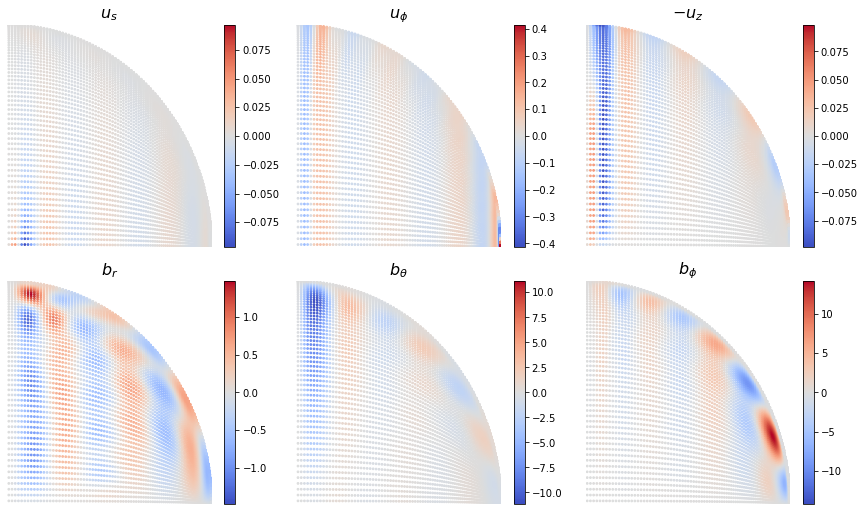

In [137]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12.2, 7.2))

# normalizer = np.abs(ueval['r']).max()
normalizer = np.abs(ueval['r']**2 + ueval['theta']**2 + ueval['phi']**2).max()

plot_fields = ['r', 'phi', 'theta']
plot_fnames = [r"$u_s$", r"$u_\phi$", r"$-u_z$"]

for i_c, comp in enumerate(plot_fields):
    # climit = 1
    if np.nanmax(np.abs(np.real(ueval[comp])))/normalizer >= 1e-7:
        climit = np.nanmax(np.abs(np.real(ueval[comp])))/normalizer
    else:
        climit = 1e-7
    ax = axes[0, i_c]
    im = ax.scatter(s_grid.flatten(), z_grid.flatten(), 3, c=np.real(ueval[comp])/normalizer, cmap='coolwarm', vmin=-climit, vmax=+climit)
    plt.colorbar(im, ax=ax)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title(plot_fnames[i_c], fontsize=16)
    ax.axis("off")

plot_fields = ['r', 'theta', 'phi']
plot_fnames = [r"$b_r$", r"$b_\theta$", r"$b_\phi$"]

for i_c, comp in enumerate(plot_fields):
    # climit = 1
    if np.nanmax(np.abs(np.real(beval[comp])))/normalizer >= 1e-7:
        climit = np.nanmax(np.abs(np.real(beval[comp])))/normalizer
    else:
        climit = 1e-7
    ax = axes[1, i_c]
    im = ax.scatter(s_grid.flatten(), z_grid.flatten(), 3, c=np.real(beval[comp])/normalizer, cmap='coolwarm', vmin=-climit, vmax=+climit)
    plt.colorbar(im, ax=ax)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title(plot_fnames[i_c], fontsize=16)
    ax.axis("off")

plt.tight_layout()
plt.show()

---
## Calculating diffusion

- Using `curl` of `VectorFieldSingleM`:

In [138]:
u_diff = usp.copy().curl().curl()
u_diff.data *= -1

b_diff = bsp.copy().curl().curl()
b_diff.data *= -1

In [36]:
u_diff.data

array([-1.33956197e-12+5.39105701e-12j, -1.12894485e-12+4.54200526e-12j,
       -1.08602238e-12+4.36744439e-12j, ...,
       -2.80870313e-14-3.70332352e-14j, -1.43793781e-14-8.94010625e-15j,
       -1.93809872e-24+2.96813649e-24j])

In [37]:
b_diff.data

array([-6.60990523e+02+1.44592367e+03j, -4.81501173e+02+1.14927447e+03j,
       -3.37242422e+02+9.96998128e+02j, ...,
       -1.00608489e-06+8.12003777e-08j,  2.73289465e-07-8.96363636e-08j,
        2.02429219e-14-6.29422729e-15j])

- Using `laplacian` of `VectorFieldSingleM`:

In [38]:
u_diff = usp.copy().laplacian()
b_diff = bsp.copy().laplacian()

In [39]:
u_diff.data

array([-1.33956197e-12+5.39105701e-12j, -1.12894485e-12+4.54200526e-12j,
       -1.08602238e-12+4.36744439e-12j, ...,
       -2.80870313e-14-3.70332352e-14j, -1.43793781e-14-8.94010625e-15j,
       -1.93809872e-24+2.96813649e-24j])

In [40]:
b_diff.data

array([-6.60990523e+02+1.44592367e+03j, -4.81501173e+02+1.14927447e+03j,
       -3.37242422e+02+9.96998128e+02j, ...,
       -1.00608489e-06+8.12003777e-08j,  2.73289465e-07-8.96363636e-08j,
        2.02429219e-14-6.29422729e-15j])

### Equatorial slice

Calculate values on the equatorial slice

In [139]:
n_phi = 200
phase = 0*np.pi
phi_grid = np.linspace(0, 2*np.pi, n_phi + 1)

udphy_eq = u_diff.equatorial_slice(worland_transform)
bdphy_eq = b_diff.equatorial_slice(worland_transform)

ud_sph = udphy_eq.at_equator(phi_grid, phase=phase)
ud_cyl = {'s': ud_sph['r'], 'phi': ud_sph['phi'], 'z': -ud_sph['theta']}
bd_sph = bdphy_eq.at_equator(phi_grid, phase=phase)
bd_cyl = {'s': bd_sph['r'], 'phi': bd_sph['phi'], 'z': -bd_sph['theta']}

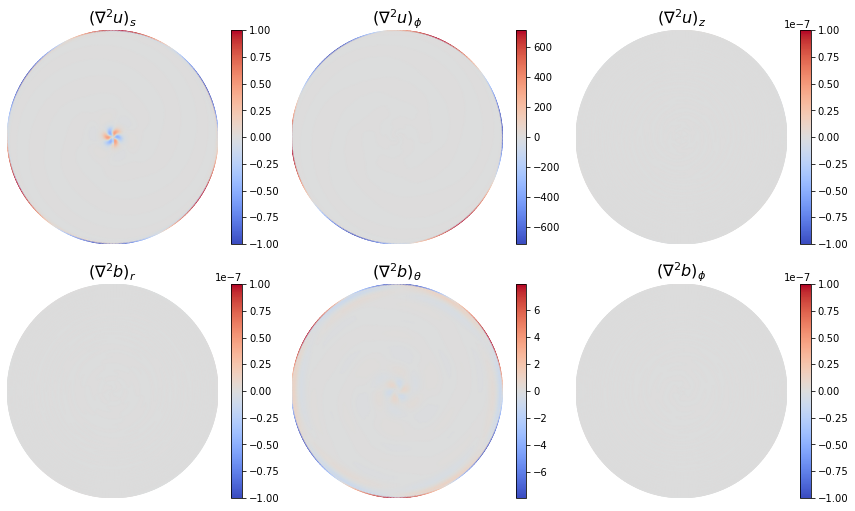

In [140]:
plot_fields = [["ud_s", "ud_p", "ud_z"],
               ["bd_r", "bd_t", "bd_p"],]
plot_fnames = [[r"$(\nabla^2 u)_s$", r"$(\nabla^2 u)_\phi$", r"$(\nabla^2 u)_z$"],
               [r"$(\nabla^2 b)_r$", r"$(\nabla^2 b)_\theta$", r"$(\nabla^2 b)_\phi$"],]

# save_name = "./runs/S1pi_Le1e-5_Lu5e+5_m3_parity_oppo/v_eq_m3_{}".format(
#     df_view["Index"][category_idx])
save_name = None
override = False

rotate_us_max = True
force_symmetric_cmap = True

max_u_norm = np.abs(ud_cyl['s']).max()
normalizer = max_u_norm

fields = {
    'ud_r': ud_sph['r'], 'ud_t': ud_sph['theta'],
    'ud_s': ud_cyl['s'], 'ud_p': ud_cyl['phi'], 'ud_z': ud_cyl['z'],
    'bd_r': bd_sph['r'], 'bd_t': bd_sph['theta'],
    'bd_s': bd_cyl['s'], 'bd_p': bd_cyl['phi'], 'bd_z': bd_cyl['z'],
}

phi_rotate = 0
if rotate_us_max:
    phi_rotate = phi_grid[np.unravel_index(np.argmax(u_cyl['s']), u_cyl['s'].shape)[0]]

rr, pp = np.meshgrid(udphy_eq.rg, phi_grid - phi_rotate)
X1, X2 = rr*np.cos(pp), rr*np.sin(pp)

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*3.6))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        field_plot = fields[fname]
        if np.abs(np.real(field_plot/normalizer)).max() > 1e-7:
            if force_symmetric_cmap:
                climit = np.max(np.abs(field_plot/normalizer))
                cm = ax.pcolormesh(X1, X2, field_plot/normalizer, shading="gouraud", cmap="coolwarm", vmin=-climit, vmax=+climit)
                plt.colorbar(cm, ax=ax)
            else:
                cm = ax.pcolormesh(X1, X2, field_plot/normalizer, shading="gouraud", cmap="coolwarm")
                plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(X1, X2, field_plot/normalizer, vmin=-1e-7, vmax=+1e-7, shading="gouraud", cmap="coolwarm")
            plt.colorbar(cm, ax=ax)
        
        ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        # ax.axis("equal")
        # ax.grid()
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.axis("off")

# fig.suptitle(r"Idx={:d}    $\lambda=${:.4e}".format(
#     category_idx, eigenvals[category_idx][mode_idx],), fontsize=16)
# fig.suptitle(r"Mode {}    $\lambda=${:.4e}".format(
#     df_view["Index"][category_idx], eigenvals[category_idx][mode_idx],), fontsize=16)
plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.tight_layout()
plt.show()

Unstructured points evaluation:
- Fourier grids in the azimuthal direction (equidistant grids in $\phi$)
- Jacobi (shown is Chebyshev) grids in the radial direction

In [146]:
from scipy.special import roots_jacobi, roots_chebyt

s_grid, _ = roots_jacobi(80, -0.5, -0.5)
s_grid = np.sqrt((1 + s_grid) / 2)
# s_grid = np.linspace(0., 1., num=100)
p_grid = np.linspace(0, 2*np.pi, num=200)
s_grid, p_grid = np.meshgrid(s_grid, p_grid)
x_pts = (s_grid*np.cos(p_grid - phi_rotate)).flatten()
y_pts = (s_grid*np.sin(p_grid - phi_rotate)).flatten()

phase = np.exp(1j*m_val*p_grid[:, 0])
ueval = u_diff.evaluate(s_grid[0, :], np.pi/2*np.ones(s_grid.shape[1]), 0.)
ueval['r'] = np.outer(phase, ueval['r']).flatten()
ueval['theta'] = np.outer(phase, ueval['theta']).flatten()
ueval['phi'] = np.outer(phase, ueval['phi']).flatten()

beval = b_diff.evaluate(s_grid[0, :], np.pi/2*np.ones(s_grid.shape[1]), 0.)
beval['r'] = np.outer(phase, beval['r']).flatten()
beval['theta'] = np.outer(phase, beval['theta']).flatten()
beval['phi'] = np.outer(phase, beval['phi']).flatten()

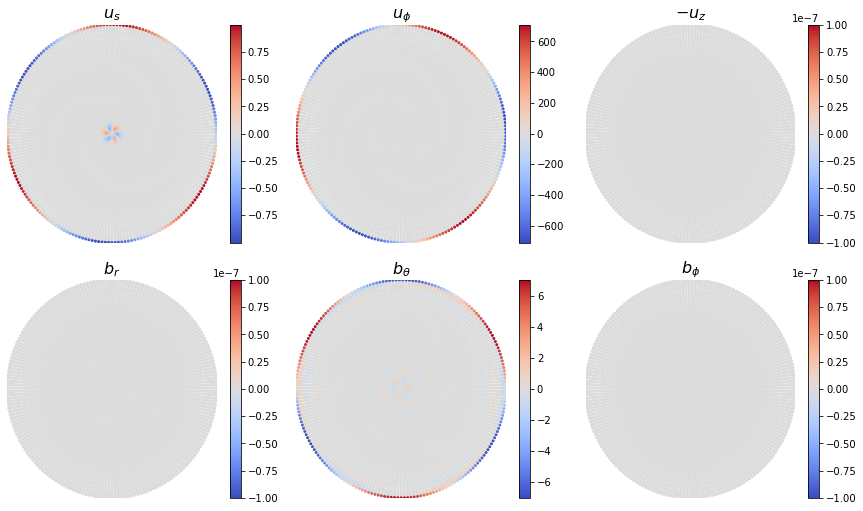

In [147]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12.2, 7.2))

normalizer = np.abs(ueval['r']).max()
# normalizer = np.sqrt(np.abs(ueval['r']**2 + ueval['theta']**2 + ueval['phi']**2).max())

plot_fields = ['r', 'phi', 'theta']
plot_fnames = [r"$u_s$", r"$u_\phi$", r"$-u_z$"]

for i_c, comp in enumerate(plot_fields):
    # climit = 1
    if np.nanmax(np.abs(np.real(ueval[comp])))/normalizer >= 1e-7:
        climit = np.nanmax(np.abs(np.real(ueval[comp])))/normalizer
    else:
        climit = 1e-7
    ax = axes[0, i_c]
    im = ax.scatter(x_pts, y_pts, 3, c=np.real(ueval[comp])/normalizer, cmap='coolwarm', vmin=-climit, vmax=+climit)
    plt.colorbar(im, ax=ax)
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_title(plot_fnames[i_c], fontsize=16)
    ax.axis("off")

plot_fields = ['r', 'theta', 'phi']
plot_fnames = [r"$b_r$", r"$b_\theta$", r"$b_\phi$"]

for i_c, comp in enumerate(plot_fields):
    # climit = 1
    if np.nanmax(np.abs(np.real(beval[comp])))/normalizer >= 1e-7:
        climit = np.nanmax(np.abs(np.real(beval[comp])))/normalizer
    else:
        climit = 1e-7
    ax = axes[1, i_c]
    im = ax.scatter(x_pts, y_pts, 3, c=np.real(beval[comp])/normalizer, cmap='coolwarm', vmin=-climit, vmax=+climit)
    plt.colorbar(im, ax=ax)
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_title(plot_fnames[i_c], fontsize=16)
    ax.axis("off")

plt.tight_layout()
plt.show()

### Meridional slice

Calculate values on a Meridional slice

In [148]:
# longitude = 0*np.pi
longitude = phi_rotate + np.pi/7

udphy_md = u_diff.physical_field(worland_transform, legendre_transform)
bdphy_md = b_diff.physical_field(worland_transform, legendre_transform)

rr, tt = np.meshgrid(udphy_md.grid['r'], udphy_md.grid['theta'])
X1, X2 = rr*np.sin(tt), rr*np.cos(tt)

ud_sph = udphy_md.at_phi(phi=longitude)
ud_cyl = {
    's': ud_sph['r']*np.sin(tt) + ud_sph['theta']*np.cos(tt),
    'phi': ud_sph['phi'],
    'z': ud_sph['r']*np.cos(tt) - ud_sph['theta']*np.sin(tt)
}
bd_sph = bdphy_md.at_phi(phi=longitude)
bd_cyl = {
    's': bd_sph['r']*np.sin(tt) + bd_sph['theta']*np.cos(tt),
    'phi': bd_sph['phi'],
    'z': bd_sph['r']*np.cos(tt) - bd_sph['theta']*np.sin(tt)
}

Visualisation

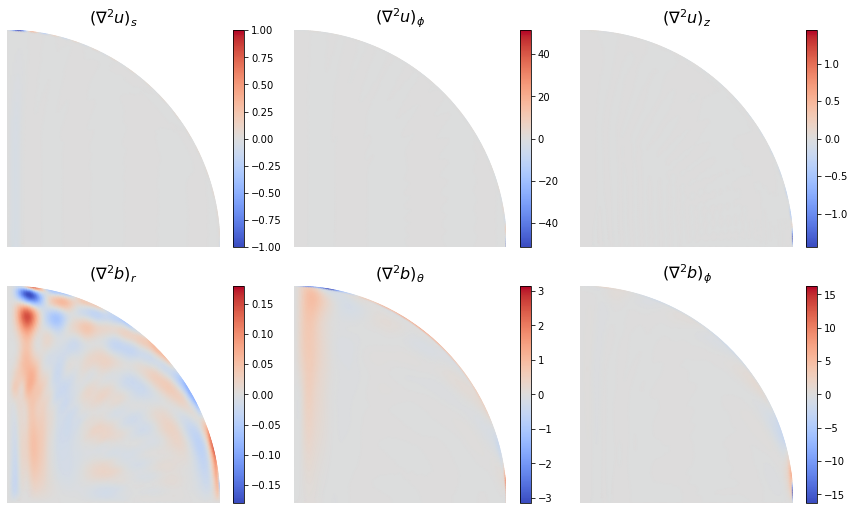

In [149]:
plot_fields = [["ud_s", "ud_p", "ud_z"],
               ["bd_r", "bd_t", "bd_p"],]
plot_fnames = [[r"$(\nabla^2 u)_s$", r"$(\nabla^2 u)_\phi$", r"$(\nabla^2 u)_z$"],
               [r"$(\nabla^2 b)_r$", r"$(\nabla^2 b)_\theta$", r"$(\nabla^2 b)_\phi$"],]

# save_name = "./runs/S1pi_Le1e-3_Lu5e+3_m3_parity_oppo/v_md_m3_{:d}".format(category_idx)
# save_name = "./runs/S1pi_Le1e-5_Lu5e+5_m3_parity_oppo/v_md_m3_{}".format(
#     df_view["Index"][category_idx])
save_name = None
override = False

force_symmetric_cmap = True

max_u_norm = np.abs(ud_cyl['s']).max()
normalizer = max_u_norm

fields = {
    'ud_r': ud_sph['r'], 'ud_t': ud_sph['theta'],
    'ud_s': ud_cyl['s'], 'ud_p': ud_cyl['phi'], 'ud_z': ud_cyl['z'],
    'bd_r': bd_sph['r'], 'bd_t': bd_sph['theta'],
    'bd_s': bd_cyl['s'], 'bd_p': bd_cyl['phi'], 'bd_z': bd_cyl['z'],
}

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*3.6))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        field_plot = fields[fname]
        if np.abs(np.real(field_plot/normalizer)).max() > 1e-7:
            # normalizer = max_u_norm if fname[0] == 'u' else max_b_norm
            normalizer = max_u_norm
            if force_symmetric_cmap:
                climit = np.max(np.abs(field_plot/normalizer))
                # if i_c == 1:
                #     climit = 1.
                cm = ax.pcolormesh(X1, X2, field_plot/normalizer, shading="gouraud", cmap="coolwarm", vmin=-climit, vmax=+climit)
                plt.colorbar(cm, ax=ax)
            else:
                cm = ax.pcolormesh(X1, X2, field_plot/normalizer, shading="gouraud", cmap="coolwarm")
                plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(X1, X2, field_plot/normalizer, shading="gouraud", cmap="coolwarm", vmin=-1e-7, vmax=+1e-7)
            plt.colorbar(cm, ax=ax)
        
        ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        # ax.axis("equal")
        # ax.grid()
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.axis("off")

# fig.suptitle(r"Idx={:d}    $\lambda=${:.4e}".format(
#     category_idx, eigenvals[category_idx][mode_idx],), fontsize=16)
# fig.suptitle(r"Mode {}    $\lambda=${:.4e}".format(
#     df_view["Index"][category_idx], eigenvals[category_idx][mode_idx],), fontsize=16)
plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.tight_layout()
plt.show()

Unstructured points evaluation:
- Transformed Jacobi (shown is Chebyshev) grids in the cylindrical radial direction
- Positive half Jacobi (shown is Chebyshev) grids in the cylindrical axial direction

In [151]:
from scipy.special import roots_jacobi

s_grid, _ = roots_jacobi(100, -.5, -.5)
s_grid = np.sqrt((1 + s_grid)/2)
z_grid, _ = roots_jacobi(120, -.5, -.5)
z_grid = z_grid[60:]
z_grid = np.outer(z_grid, np.sqrt(1 - s_grid**2))
s_grid = s_grid*np.ones_like(z_grid)

plot_fields = ['r', 'theta', 'phi']
plot_fnames = [r"$B_r$", r"$B_\theta$", r"$B_\phi$"]

r_pts, t_pts, p_pts = pgpy_utils.coord_cart2sph(s_grid.flatten(), np.array(0.), z_grid.flatten())
ueval = u_diff.evaluate(r_pts, t_pts, longitude)
beval = b_diff.evaluate(r_pts, t_pts, longitude)

In [172]:
ueval_cyl = {
    's': ueval['r']*np.sin(t_pts) + ueval['theta']*np.cos(t_pts),
    'phi': ueval['phi'],
    'z': ueval['r']*np.cos(t_pts) - ueval['theta']*np.sin(t_pts)
}

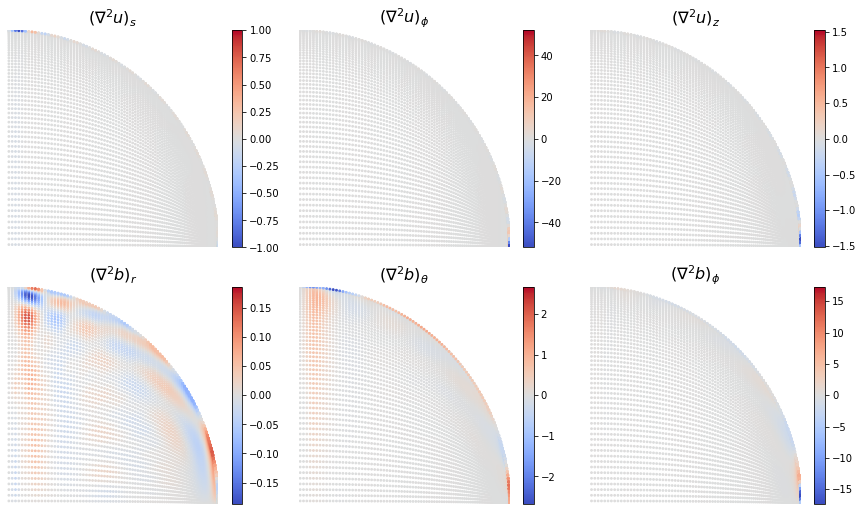

In [177]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12.2, 7.2))

normalizer = np.abs(np.real(ueval_cyl['s'])).max()
# normalizer = np.sqrt(np.abs(ueval['r']**2 + ueval['theta']**2 + ueval['phi']**2).max())

plot_fields = ['s', 'phi', 'z']
plot_fnames = [r"$(\nabla^2 u)_s$", r"$(\nabla^2 u)_\phi$", r"$(\nabla^2 u)_z$"]

for i_c, comp in enumerate(plot_fields):
    # climit = 1
    if np.nanmax(np.abs(np.real(ueval_cyl[comp])))/normalizer >= 1e-7:
        climit = np.nanmax(np.abs(np.real(ueval_cyl[comp])))/normalizer
    else:
        climit = 1e-7
    ax = axes[0, i_c]
    im = ax.scatter(s_grid.flatten(), z_grid.flatten(), 3, c=np.real(ueval_cyl[comp])/normalizer, cmap='coolwarm', vmin=-climit, vmax=+climit)
    plt.colorbar(im, ax=ax)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title(plot_fnames[i_c], fontsize=16)
    ax.axis("off")

plot_fields = ['r', 'theta', 'phi']
plot_fnames = [r"$(\nabla^2 b)_r$", r"$(\nabla^2 b)_\theta$", r"$(\nabla^2 b)_\phi$"]

for i_c, comp in enumerate(plot_fields):
    # climit = 1
    if np.nanmax(np.abs(np.real(beval[comp])))/normalizer >= 1e-7:
        climit = np.nanmax(np.abs(np.real(beval[comp])))/normalizer
    else:
        climit = 1e-7
    ax = axes[1, i_c]
    im = ax.scatter(s_grid.flatten(), z_grid.flatten(), 3, c=np.real(beval[comp])/normalizer, cmap='coolwarm', vmin=-climit, vmax=+climit)
    plt.colorbar(im, ax=ax)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title(plot_fnames[i_c], fontsize=16)
    ax.axis("off")

plt.tight_layout()
plt.show()

### Laplacian operator on the spectrum

In [81]:
from scipy import sparse as scsp

m = 3
maxnl = 63
nr = 63
n_grid = nr + maxnl // 2 + 10
rg = poly.worland_grid(n_grid)
weight = scsp.diags(np.ones(n_grid)*poly.worland_weight(n_grid))
w_poly = poly.worland(nr, maxnl - 1, rg)

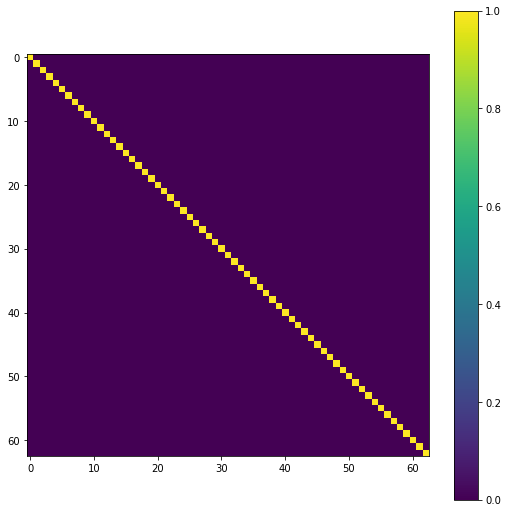

In [85]:
plt.figure(figsize=(9, 9))
plt.imshow(w_poly.T @ weight @ w_poly)
plt.colorbar()
plt.show()

---
## Background SH fields

Load a single SH mode as a background field

In [118]:
import models
from operators.polynomials import SphericalHarmonicMode
from operators.worland_transform import WorlandTransform
from operators.associated_legendre_transform import AssociatedLegendreTransformSingleM
from fields import VectorFieldSingleM
from scipy import interpolate

# mode_SH = SphericalHarmonicMode("pol", 1, 0, "1/5 Sqrt[pi/3] r(5 - 3r^2)")
# mode_SH = SphericalHarmonicMode("pol", 2, 0, "1/4 Sqrt[3/26] r^2(5r^2 - 7)")
mode_SH = SphericalHarmonicMode("pol", 2, 0, "5/14 Sqrt[3/182] r^2(157 - 296r^2 + 143r^4)")

nr, maxnl, m_val = 10, 3, 0

mode_bg = VectorFieldSingleM.from_SH_mode(nr, maxnl, mode_SH)

In [10]:
mode_bg.laplacian()

VectorFieldSingleM(nr=5, maxnl=3, m=0)

In [119]:
mode_bg.data

array([ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+

In [120]:
rg = np.linspace(0, 1, 201)
tg = np.linspace(0, np.pi/2, 201)
worland_transform = WorlandTransform(nr, maxnl, m_val, r_grid=rg)
legendre_transform = AssociatedLegendreTransformSingleM(maxnl, m_val, tg)

### Equatorial slice

Calculate values on the equatorial slice

In [5]:
n_phi = 200
phase = 0*np.pi
phi_grid = np.linspace(0, 2*np.pi, n_phi + 1)

bphy_eq = mode_bg.equatorial_slice(worland_transform)
r_grid = bphy_eq.rg
rr, pp = np.meshgrid(r_grid, phi_grid)

b_sph = bphy_eq.at_equator(phi_grid, phase=phase)
b_cyl = {'s': b_sph['r'], 'phi': b_sph['phi'], 'z': -b_sph['theta']}
bx, by, bz, _, _, _ = pgpy_utils.vector_sph2cart(b_sph['r'], b_sph['theta'], b_sph['phi'], rr, np.pi/2*np.ones_like(rr), pp)
b_cart = {'x': bx, 'y': by, 'z': bz}

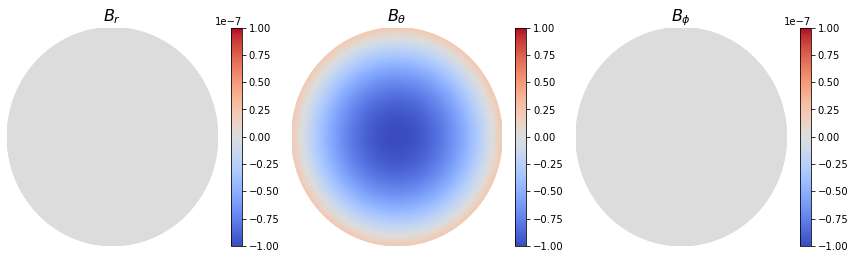

In [6]:
plot_fields = [["b_r", "b_t", "b_p"],]
plot_fnames = [[r"$B_r$", r"$B_\theta$", r"$B_\phi$"],]

# save_name = "./runs/S1pi_Le1e-5_Lu5e+5_m3_parity_oppo/v_eq_m3_{}".format(
#     df_view["Index"][category_idx])
save_name = None
override = False

rotate_us_max = False
force_symmetric_cmap = True
force_lines = True

normalizer = 1

fields = {
    'b_r': b_sph['r'], 'b_t': b_sph['theta'],
    'b_s': b_cyl['s'], 'b_p': b_cyl['phi'], 'b_z': b_cyl['z'],
    'b_x': b_cart['x'], 'b_y': b_cart['y']
}

phi_rotate = 0
if rotate_us_max:
    phi_rotate = phi_grid[np.unravel_index(np.argmax(b_cyl['s']), b_cyl['s'].shape)[0]]

rr, pp = np.meshgrid(bphy_eq.rg, phi_grid - phi_rotate)
X1, X2 = rr*np.cos(pp), rr*np.sin(pp)

if force_lines:
    x_grid = np.linspace(-1., 1., num=20)
    y_grid = np.linspace(-1., 1., num=20)
    XX, YY = np.meshgrid(x_grid, y_grid)
    Bx_grid = interpolate.griddata((X1.flatten(), X2.flatten()), fields['b_x'].flatten(), (XX, YY))
    By_grid = interpolate.griddata((X1.flatten(), X2.flatten()), fields['b_y'].flatten(), (XX, YY))
    # p_idx = slice(None, None, 10)
    # r_idx = slice(None, None, 20)
    # X1_grid = X1[p_idx, r_idx]
    # X2_grid = X2[p_idx, r_idx]
    # Bx_grid = fields['b_x'][p_idx, r_idx]
    # By_grid = fields['b_y'][p_idx, r_idx]

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*3.7))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        field_plot = fields[fname]
        if np.abs(np.real(field_plot/normalizer)).max() > 1e-7:
            if force_symmetric_cmap:
                climit = np.max(np.abs(field_plot/normalizer))
                cm = ax.pcolormesh(X1, X2, field_plot/normalizer, shading="gouraud", cmap="coolwarm", vmin=-climit, vmax=+climit)
                plt.colorbar(cm, ax=ax)
            else:
                cm = ax.pcolormesh(X1, X2, field_plot/normalizer, shading="gouraud", cmap="coolwarm")
                plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(X1, X2, field_plot/normalizer, vmin=-1e-7, vmax=+1e-7, shading="gouraud", cmap="coolwarm")
            plt.colorbar(cm, ax=ax)
        
        if force_lines and np.nanmax(Bx_grid**2 + By_grid**2) > 1e-10:
            # ax.quiver(XX, YY, Bx_grid, By_grid, color='k', scale=5., scale_units='inches')
            ax.streamplot(XX, YY, Bx_grid, By_grid, color='k', density=0.5, minlength=.2)
        
        ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        # ax.axis("equal")
        # ax.grid()
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.axis("off")

# fig.suptitle(r"Idx={:d}    $\lambda=${:.4e}".format(
#     category_idx, eigenvals[category_idx][mode_idx],), fontsize=16)
# fig.suptitle(r"Mode {}    $\lambda=${:.4e}".format(
#     df_view["Index"][category_idx], eigenvals[category_idx][mode_idx],), fontsize=16)
plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.tight_layout()
plt.show()

Unstructured points evaluation:
- Fourier grids in the azimuthal direction (equidistant grids in $\phi$)
- Jacobi (shown is Chebyshev) grids in the radial direction

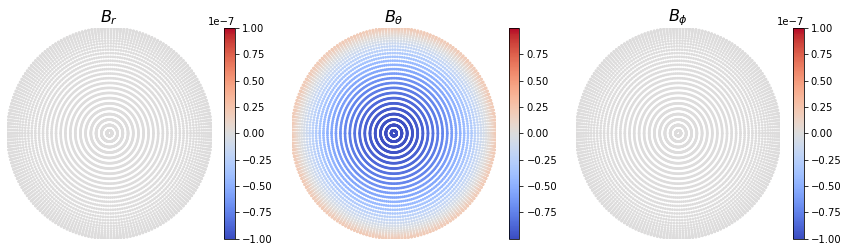

In [29]:
from scipy.special import roots_jacobi, roots_chebyt

p_grid = np.linspace(0, 2*np.pi, num=100)
s_grid, _ = roots_jacobi(60, -0.5, -0.5)
s_grid, p_grid = np.meshgrid(s_grid, p_grid)
x_pts = (s_grid*np.cos(p_grid)).flatten()
y_pts = (s_grid*np.sin(p_grid)).flatten()

# x_grid = np.linspace(-1, 1, num=80)
# y_grid = np.linspace(-1, 1, num=80)
# x_grid, y_grid = np.meshgrid(x_grid, y_grid)
# x_pts = x_grid.flatten()
# y_pts = y_grid.flatten()
# in_circ = x_pts**2 + y_pts**2 <= 1.
# x_pts = x_pts[in_circ]
# y_pts = y_pts[in_circ]

r_pt, t_pt, p_pt = pgpy_utils.coord_cart2sph(x_pts, y_pts, np.zeros_like(x_pts))
feval = mode_bg.evaluate(r_pt, t_pt, p_pt)

plot_fields = ['r', 'theta', 'phi']
plot_fnames = [r"$B_r$", r"$B_\theta$", r"$B_\phi$"]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3.6))

for i_c, comp in enumerate(plot_fields):
    if np.max(np.abs(np.real(feval[comp]))) >= 1e-7:
        climit = np.max(np.abs(np.real(feval[comp])))
    else:
        climit = 1e-7
    ax = axes[i_c]
    im = ax.scatter(x_pts, y_pts, 3, c=np.real(feval[comp]), cmap='coolwarm', vmin=-climit, vmax=+climit)
    plt.colorbar(im, ax=ax)
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_title(plot_fnames[i_c], fontsize=16)
    ax.axis("off")        

plt.tight_layout()
plt.show()

### Meridional slice

Calculate values on a Meridional slice

In [121]:
# Axisymmetric background field: longitude invariant
longitude = 0*np.pi
# longitude = phi_rotate + np.pi/7

bphy_md = mode_bg.physical_field(worland_transform, legendre_transform)

rr, tt = np.meshgrid(bphy_md.grid['r'], bphy_md.grid['theta'])
X1, X2 = rr*np.sin(tt), rr*np.cos(tt)

b_sph = bphy_md.at_phi(phi=longitude)
b_cyl = {
    's': b_sph['r']*np.sin(tt) + b_sph['theta']*np.cos(tt),
    'phi': b_sph['phi'],
    'z': b_sph['r']*np.cos(tt) - b_sph['theta']*np.sin(tt)
}
bx, by, bz, _, _, _ = pgpy_utils.vector_sph2cart(b_sph['r'], b_sph['theta'], b_sph['phi'], rr, tt, longitude*np.ones_like(rr))
b_cart = {'x': bx, 'y': by, 'z': bz}

Visualisation

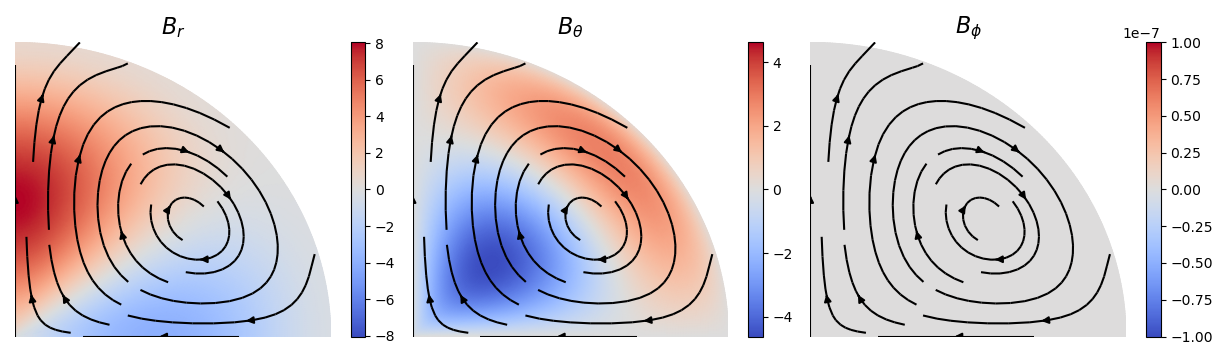

In [123]:
plot_fields = [["b_r", "b_t", "b_p"],]
plot_fnames = [[r"$B_r$", r"$B_\theta$", r"$B_\phi$"],]

# save_name = "./out/S1_bg"
# save_name = "./runs/S1pi_Le1e-3_Lu5e+3_m3_parity_oppo/v_md_m3_{:d}".format(category_idx)
# save_name = "./runs/S1pi_Le1e-5_Lu5e+5_m3_parity_oppo/v_md_m3_{}".format(
#     df_view["Index"][category_idx])
save_name = None
override = False

force_symmetric_cmap = True
force_lines = True

normalizer = 1

fields = {
    'b_r': b_sph['r'], 'b_t': b_sph['theta'],
    'b_s': b_cyl['s'], 'b_p': b_cyl['phi'], 'b_z': b_cyl['z'],
    'b_x': b_cart['x'], 'b_y': b_cart['y']
}

if force_lines:
    x_grid = np.linspace(0., 1., num=100)
    y_grid = np.linspace(0., 1., num=100)
    XX, YY = np.meshgrid(x_grid, y_grid)
    Bx_grid = interpolate.griddata((X1.flatten(), X2.flatten()), fields['b_s'].flatten(), (XX, YY))
    By_grid = interpolate.griddata((X1.flatten(), X2.flatten()), fields['b_z'].flatten(), (XX, YY))
    # p_idx = slice(None, None, 10)
    # r_idx = slice(None, None, 10)
    # X1_grid = X1[p_idx, r_idx]
    # X2_grid = X2[p_idx, r_idx]
    # Bx_grid = fields['b_s'][p_idx, r_idx]
    # By_grid = fields['b_z'][p_idx, r_idx]

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4.1, nrows*3.6))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        field_plot = fields[fname]
        if np.abs(np.real(field_plot/normalizer)).max() > 1e-7:
            # normalizer = max_u_norm if fname[0] == 'u' else max_b_norm
            if force_symmetric_cmap:
                climit = np.max(np.abs(field_plot/normalizer))
                # if i_c == 1:
                #     climit = 1.
                cm = ax.pcolormesh(X1, X2, field_plot/normalizer, shading="gouraud", cmap="coolwarm", vmin=-climit, vmax=+climit)
                plt.colorbar(cm, ax=ax)
            else:
                cm = ax.pcolormesh(X1, X2, field_plot/normalizer, shading="gouraud", cmap="coolwarm")
                plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(X1, X2, field_plot/normalizer, shading="gouraud", cmap="coolwarm", vmin=-1e-7, vmax=+1e-7)
            plt.colorbar(cm, ax=ax)
        
        if force_lines:
            # ax.quiver(XX, YY, Bx_grid, By_grid, color='k', scale=10., scale_units='inches')
            ax.streamplot(XX, YY, Bx_grid, By_grid, color='k', density=0.5, minlength=.2)
        
        ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        # ax.axis("equal")
        # ax.grid()
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.axis("off")

# fig.suptitle(r"Idx={:d}    $\lambda=${:.4e}".format(
#     category_idx, eigenvals[category_idx][mode_idx],), fontsize=16)
# fig.suptitle(r"Mode {}    $\lambda=${:.4e}".format(
#     df_view["Index"][category_idx], eigenvals[category_idx][mode_idx],), fontsize=16)
plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.tight_layout()
plt.show()

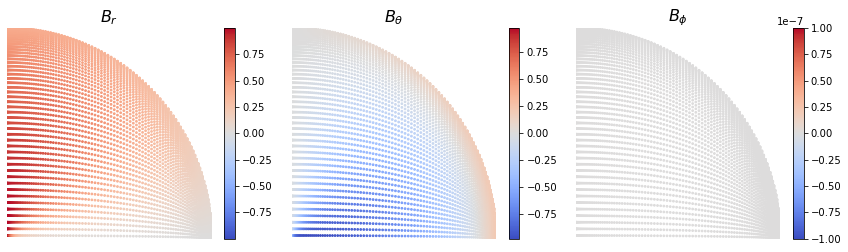

In [42]:
from scipy.special import roots_jacobi

s_grid, _ = roots_jacobi(100, -.5, -.5)
s_grid = (1 + s_grid)/2
z_grid, _ = roots_jacobi(100, -.5, -.5)
z_grid = z_grid[50:]
z_grid = np.outer(z_grid, np.sqrt(1 - s_grid**2))
s_grid = s_grid*np.ones_like(z_grid)

plot_fields = ['r', 'theta', 'phi']
plot_fnames = [r"$B_r$", r"$B_\theta$", r"$B_\phi$"]

r_pt, t_pt, p_pt = pgpy_utils.coord_cart2sph(s_grid.flatten(), np.array(0.), z_grid.flatten())
feval = mode_bg.evaluate(r_pt, t_pt, p_pt)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3.6))

for i_c, comp in enumerate(plot_fields):
    if np.max(np.abs(np.real(feval[comp]))) >= 1e-7:
        climit = np.max(np.abs(np.real(feval[comp])))
    else:
        climit = 1e-7
    ax = axes[i_c]
    im = ax.scatter(s_grid.flatten(), z_grid.flatten(), 3, c=np.real(feval[comp]), cmap='coolwarm', vmin=-climit, vmax=+climit)
    plt.colorbar(im, ax=ax)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title(plot_fnames[i_c], fontsize=16)
    ax.axis("off")        

plt.tight_layout()
plt.show()